# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection

from scipy.optimize import minimize

## 0.2. Parâmetros do problema

In [2]:
SCALE = 1.0 # How much each screen element is going to be scaled. Default is 1.0
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30 # The width of the screen that contains the overlapping windows in pixels
MAX_WINDOW_DIM = 3 # The max height or width each window can have. For the project the default is 3.
MIN_WINDOW_DIM = 2 # The minimum height or width each window can have. For the project the default is 2.
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 7 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 7 # How far the points can be from the cluster in pixels
KNN_K = 3 # The number of closest neighbors considered for building the connectivity graph

## 0.3. Preprocessamento dos parâmetros

In [3]:
# Rescale
SCREEN_HEIGHT *= SCALE
SCREEN_WIDTH *= SCALE
MAX_WINDOW_DIM *= SCALE
MIN_WINDOW_DIM *= SCALE
CLUSTER_DISTANCE_FROM_SCREEN_CENTER *= SCALE
POINT_DISTANCE_FROM_CLUSTER *= SCALE

SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, de forma que $P_j=(x_j,y_j,h_j,w_j)$. A nivel de implementação, o ponto ainda possui a informação do cluster ao qual ele pertence.

## 1.1 Gerar Centros

In [4]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis

clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [5]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) #

j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER/2,POINT_DISTANCE_FROM_CLUSTER/2, 2)
        # Point dimension
        points[j,2:4] = random.randint(MIN_WINDOW_DIM,MAX_WINDOW_DIM+1,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1
        
points_pos = points[:,:2] # position vectors
points_dims = points[:,2:4] # dimension vectors

## 1.3 Mostrar os dados

<Figure size 432x288 with 0 Axes>

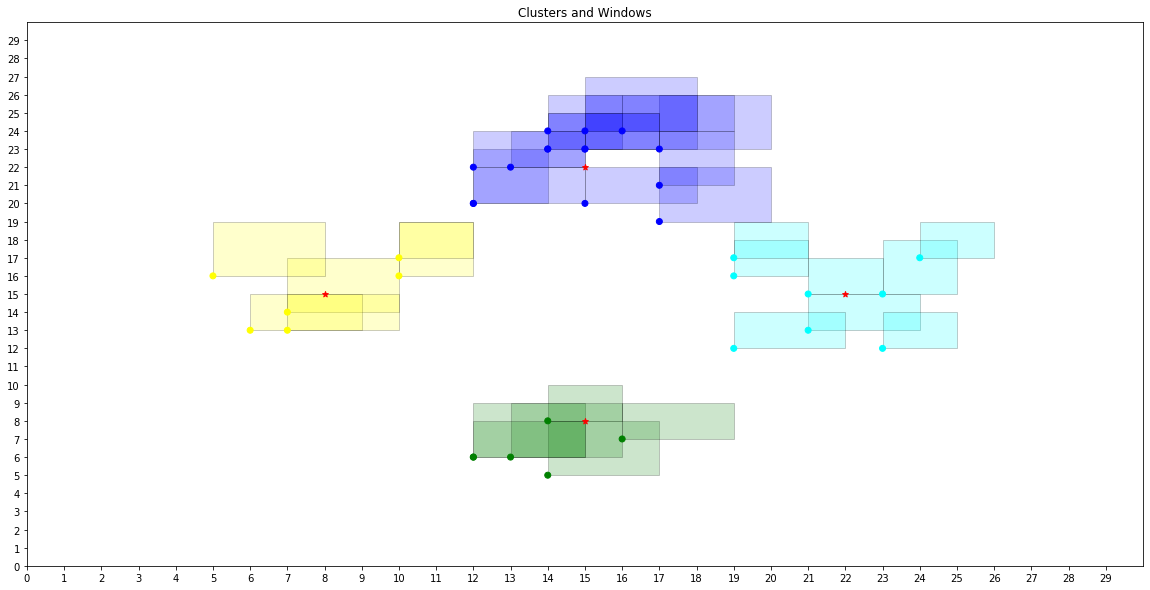

In [6]:
def draw_windows(window_clusters, window_points, window_dims, window_cluster_ids, n_clusters, group_size_list):
    clf()
    fig, ax = subplots(1, figsize=(20,10))
    ax.set_title("Clusters and Windows")
    ax.set_xlim(0, SCREEN_WIDTH)
    ax.set_ylim(0, SCREEN_HEIGHT)
    ax.set_xticks(arange(0, SCREEN_WIDTH, 1 * SCALE))
    ax.set_yticks(arange(0, SCREEN_HEIGHT, 1 * SCALE))
    
    # Draw Rectangles
    rect_clusters_list = [[] for i in range(n_clusters)]
    for j in range(sum(group_size_list)):
        point = window_points[j]
        dim = window_dims[j]
        idx = window_cluster_ids[j]
        rect = Rectangle((point[0], point[1]), dim[0], dim[1])
        rect_clusters_list[int(idx)].append(rect)
    color_list = ["cyan", "blue", "yellow", "green", "magenta", "gray", "black"]
    for i in range(n_clusters):
        rect_list = rect_clusters_list[i]
        pc = PatchCollection(rect_list, facecolor=color_list[i], edgecolor="k", alpha=0.2)
        ax.add_collection(pc)
        
    # Plot points
    colors_idx=window_cluster_ids[:].astype('int32')
    colors = [ color_list[color_idx] for color_idx in colors_idx]
    scatter(window_points[:,0], window_points[:,1], c=colors)

    # Plot Clusters
    ax.scatter(window_clusters[:,0], window_clusters[:,1], c="red", marker="*")
    return

draw_windows(clusters, points_pos, points_dims, points[:,4], n_groups, size_groups)

# 2. Modelagem Matemática


O problema se resume a maximizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [7]:
def plus_operator(val):
    if val > 0:
        return val
    return 0.0

def O_ij(s_i, delta_s_i, s_j, delta_s_j):
    ret_val = 0
    if(s_i >= s_j):
        ret_val =  (1./(delta_s_j ** 4)) * plus_operator(delta_s_j ** 2 - (s_i - s_j) ** 2) ** 2
    else:
        ret_val =  (1./(delta_s_i ** 4)) * plus_operator(delta_s_i ** 2 - (s_i - s_j) ** 2) ** 2
    return ret_val

def connection_graph(X):
    N = X.shape[0]
    G = zeros((N,N))
    for from_idx in range(N):
        # Compute the distance from point p_from to the other points
        p_from = X[from_idx]
        dist_list = zeros((N))
        for for_idx in range(from_idx+1, N):
            p_for = X[for_idx]
            dist_list[for_idx] = linalg.norm(p_from - p_for)
        # Find the indices of the closest K points to p_from
        closest_ids = argsort(dist_list)[:KNN_K]
        # Connect them in the graph (connection value is their distance, which is != 0)
        for idx in closest_ids:
            G[from_idx, idx] = 1.0
            G[idx, from_idx] = 1.0
    return G

def laplacian_graph(G):
    N = G.shape[0]
    L = zeros((N,N))
    for from_idx in range(N):
        for for_idx in range(N):
            # Points are different and connected
            if(from_idx != for_idx and G[from_idx, for_idx] != 0):
                degree = 0.0
                for idx in range(N):
                    if(G[from_idx, idx] != 0):
                        degree += 1.0
                L[from_idx, for_idx] = -1./(1.0 * degree)
            # Same points
            elif(from_idx == for_idx):
                L[from_idx, for_idx] = 1.0
            # Different points and disconnected
            else:
                L[from_idx, for_idx] = 0.0
    return L

In [8]:
def E_O(X):
    X = reshape(X, (points.shape[0], 2))
    sum_e = 0
    n = X.shape[0]
    for i in range(n):
        point_i = X[i]
        # Horizontal
        x_i = point_i[0]
        h_i = points_dims[i,0]
        # Vertical
        y_i = point_i[1]
        v_i = points_dims[i,1]
        for j in range(i+1,X.shape[0]):
            point_j = X[j]
            # Horizontal
            x_j = point_j[0]
            h_j = points_dims[j,0]
            overlapping_h = O_ij(x_i, h_i, x_j, h_j)
            # Vertical
            y_j = point_j[1]
            v_j = points_dims[j,1]
            overlapping_v = O_ij(y_i, v_i, y_j, v_j)
            # Sum
            sum_e += overlapping_h * overlapping_v
    sum_e = 2.0 / (n * (n+1) ) * sum_e
    return 100 * sum_e

def E_N(X):
    N = points.shape[0]
    X = reshape(X, (N,2))
    # Build connectivy graph G, where the closest k points are connected (nothing related to class was addressed)
    """
    G = zeros((N,N))
    for from_idx in range(N):
        # Compute the distance from point p_from to the other points
        p_from = X[from_idx]
        dist_list = zeros((N))
        for for_idx in range(from_idx+1, N):
            p_for = X[for_idx]
            dist_list[for_idx] = linalg.norm(p_from - p_for)
        # Find the indices of the closest K points to p_from
        closest_ids = argsort(dist_list)[:KNN_K]
        # Connect them in the graph (connection value is their distance, which is != 0)
        for idx in closest_ids:
            G[from_idx, idx] = 1.0
            G[idx, from_idx] = 1.0
    L = zeros((N,N))
    for from_idx in range(N):
        for for_idx in range(N):
            # Points are different and connected
            if(from_idx != for_idx and G[from_idx, for_idx] != 0):
                degree = 0.0
                for idx in range(N):
                    if(G[from_idx, idx] != 0):
                        degree += 1.0
                L[from_idx, for_idx] = -1./(1.0 * degree)
            # Same points
            elif(from_idx == for_idx):
                L[from_idx, for_idx] = 1.0
            # Different points and disconnected
            else:
                L[from_idx, for_idx] = 0.0
    """
    G = connection_graph(X)
    # Build the Laplacian graph
    L = laplacian_graph(G)
    delta_x = L.dot(points_pos[:,0])
    delta_y = L.dot(points_pos[:,1])
    w = 1.0 # TODO
    norm_factor = (N ** 2.0)/( 2.0 * (linalg.norm(delta_x) ** 2 +linalg.norm(delta_y) ** 2) )
    diff_x = linalg.norm( L.dot(X[:,0]) - w * delta_x ) ** 2
    diff_y = linalg.norm(L.dot(X[:,1]) - w * delta_y) ** 2 
    diff_factor = ( diff_x + diff_y)
    sum_e = norm_factor * diff_factor
    return sum_e

# 3. Solução Numérica

In [9]:
alpha = 0.15
def f (x):
    e_n = E_N(x)
    e_o = E_O(x)
    print("E_N(X)={} | E_O(X)={}".format(e_n, e_o) )
    return alpha * e_n + (1- alpha) * e_o

## RESTRICOES
#### ATENCAO: AS RESTRICOES DE DESIGUALDADE NO SCIPY SAO O OPOSTO: SAO DO TIPO r(X) >= 0!
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
x_min = 0
x_max = SCREEN_WIDTH
y_min = 0
y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 
#     <=> x_i - x_min >= 0
def constr_fun_1(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X, (points.shape[0], 2))
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = x_min - X[i,0]
        constr[i] = X[i,0] - x_min
    return constr

# r2: x_i - x_max + h_i <= 0 
#     <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X, (points.shape[0], 2))
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = - x_max + X[i,0] + points_dims[i,0]
        constr[i] = x_max - X[i,0] - points_dims[i,0] - 1
    return constr

# r3: y_min-y_i <= 0 
#     <=> y_i - y_min >= 0
def constr_fun_3(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X, (points.shape[0], 2))
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = X[i,1] -  y_min
        #constr[i] = -X[i,1] + y_min
    return constr

# r4: y_i - y_max + v_i <= 0
#     <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X, (points.shape[0], 2))
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = x_max - X[i,1]  - points_dims[i,1] - 1
        #constr[i] = - x_max + X[i,1]  + points_dims[i,1]
    return constr


cons = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

bounds = []
for idx in range(points_pos.shape[0]):
    point_bound_x = (x_min, x_max - points_dims[idx,0]-1)
    point_bound_y = (y_min, y_max - points_dims[idx,1]-1)
    bounds.append(point_bound_x)
    bounds.append(point_bound_y)

res = minimize(f, points_pos, method='SLSQP', constraints=cons, tol=1e-5, options={"maxiter" : 1e2})

E_N(X)=0.0 | E_O(X)=3.9084418275197583
E_N(X)=0.0 | E_O(X)=3.9084418275197583
E_N(X)=2.428101134231922e-16 | E_O(X)=3.9084418275197583
E_N(X)=2.4281013875407567e-16 | E_O(X)=3.9084418264247294
E_N(X)=1.232435017240935e-16 | E_O(X)=3.9084418280672732
E_N(X)=1.2324347100537184e-16 | E_O(X)=3.9084418281767763
E_N(X)=1.2324346425047254e-16 | E_O(X)=3.9084418275197583
E_N(X)=1.2324349585376056e-16 | E_O(X)=3.9084418275197583
E_N(X)=7.230470633281778e-17 | E_O(X)=3.9084418268627408
E_N(X)=7.230470995151629e-17 | E_O(X)=3.9084418280672732
E_N(X)=7.230471164024322e-17 | E_O(X)=3.9084418275197583
E_N(X)=7.230470609157153e-17 | E_O(X)=3.908441829293706
E_N(X)=7.230470633281778e-17 | E_O(X)=3.9084418269722443
E_N(X)=7.230470995151629e-17 | E_O(X)=3.9084418268627408
E_N(X)=7.230470826279143e-17 | E_O(X)=3.9084418281767763
E_N(X)=7.230470609157153e-17 | E_O(X)=3.9084418280672732
E_N(X)=7.230470971026957e-17 | E_O(X)=3.9084418275197583
E_N(X)=7.230470826278939e-17 | E_O(X)=3.9084418257458107
E_N(X)=

E_N(X)=5.793466739478925 | E_O(X)=1.7776007301202434
E_N(X)=5.793466746608647 | E_O(X)=1.777600729719224
E_N(X)=5.793466746582059 | E_O(X)=1.7776007295969922
E_N(X)=5.793466743406164 | E_O(X)=1.7776007303812151
E_N(X)=5.793466743248597 | E_O(X)=1.7776007303929302
E_N(X)=5.793466745216617 | E_O(X)=1.777600729502335
E_N(X)=5.793466749542659 | E_O(X)=1.7776007306508812
E_N(X)=5.793466753906209 | E_O(X)=1.7776007281981108
E_N(X)=5.7934667464587 | E_O(X)=1.7776007297741936
E_N(X)=5.793466751053644 | E_O(X)=1.7776007307636
E_N(X)=5.793466741206153 | E_O(X)=1.77760072962263
E_N(X)=5.793466737470627 | E_O(X)=1.777600729585018
E_N(X)=5.7934667447948325 | E_O(X)=1.7776007316050026
E_N(X)=5.793466748858373 | E_O(X)=1.7776007300807202
E_N(X)=5.793466744746684 | E_O(X)=1.7776007302499754
E_N(X)=5.793466744034571 | E_O(X)=1.777600730722775
E_N(X)=5.793466741696843 | E_O(X)=1.7776007318053
E_N(X)=5.7934667449189154 | E_O(X)=1.7776007299628638
E_N(X)=5.793466746719717 | E_O(X)=1.7776007301318009
E_N(X

E_N(X)=1.8423714114391756 | E_O(X)=2.04782953567313
E_N(X)=1.8423714083596419 | E_O(X)=2.047829535593742
E_N(X)=1.842371407565523 | E_O(X)=2.047829536651465
E_N(X)=1.8423714098991764 | E_O(X)=2.047829535474102
E_N(X)=1.8423714100388975 | E_O(X)=2.0478295353537757
E_N(X)=1.8423714080524438 | E_O(X)=2.047829537689073
E_N(X)=1.8423714139791267 | E_O(X)=2.047829536122825
E_N(X)=1.842371409966215 | E_O(X)=2.0478295355847465
E_N(X)=1.8423714048876112 | E_O(X)=2.047829535779687
E_N(X)=1.842371404767532 | E_O(X)=2.0478295374091413
E_N(X)=1.8423714129328181 | E_O(X)=2.0478295313901382
E_N(X)=1.8423714163343328 | E_O(X)=2.0478295339238333
E_N(X)=1.842371414967357 | E_O(X)=2.047829533266399
E_N(X)=1.8423714103313464 | E_O(X)=2.047829536422519
E_N(X)=1.8423714086056167 | E_O(X)=2.0478295360390373
E_N(X)=1.8423714097023356 | E_O(X)=2.0478295340885535
E_N(X)=1.8423714186345406 | E_O(X)=2.0478295321165136
E_N(X)=1.842371415863675 | E_O(X)=2.047829533325224
E_N(X)=1.8423714015448573 | E_O(X)=2.0478295

E_N(X)=3.870282462113007 | E_O(X)=1.388213471097155
E_N(X)=3.8702824570042886 | E_O(X)=1.3882134716772954
E_N(X)=3.8702824387264685 | E_O(X)=1.388213473477963
E_N(X)=3.870282438933048 | E_O(X)=1.3882134740837622
E_N(X)=3.8702824541871013 | E_O(X)=1.3882134722576411
E_N(X)=3.8702824569484173 | E_O(X)=1.3882134719063128
E_N(X)=3.870282449926812 | E_O(X)=1.388213472854361
E_N(X)=3.8702824499739323 | E_O(X)=1.388213472191925
E_N(X)=3.870282444683058 | E_O(X)=1.38821347370681
E_N(X)=3.870282452877186 | E_O(X)=1.388213472092343
E_N(X)=3.8702824571703998 | E_O(X)=1.3882134720197572
E_N(X)=3.870282449471714 | E_O(X)=1.3882134729583535
E_N(X)=3.8702824504259143 | E_O(X)=1.3882134724480002
E_N(X)=3.8702824452262723 | E_O(X)=1.3882134737921636
E_N(X)=3.870282446124281 | E_O(X)=1.388213472799511
E_N(X)=3.870282450633192 | E_O(X)=1.3882134729697908
E_N(X)=3.8702824563624803 | E_O(X)=1.3882134714485008
E_N(X)=3.8702824572134253 | E_O(X)=1.3882134714159764
E_N(X)=3.8702824457415 | E_O(X)=1.3882134729

E_N(X)=4.925963955207913 | E_O(X)=0.9837276536194514
E_N(X)=4.925963944803682 | E_O(X)=0.9837276551173394
E_N(X)=4.925963939398611 | E_O(X)=0.9837276552865657
E_N(X)=4.925963943683364 | E_O(X)=0.9837276556008566
E_N(X)=4.925963949173052 | E_O(X)=0.9837276538685004
E_N(X)=4.925963941117079 | E_O(X)=0.9837276555278355
E_N(X)=4.925963952141006 | E_O(X)=0.9837276537544962
E_N(X)=4.925963948775892 | E_O(X)=0.9837276543239548
E_N(X)=4.925963946194295 | E_O(X)=0.9837276543840592
E_N(X)=4.9259639533238335 | E_O(X)=0.983727653542467
E_N(X)=4.925963956801015 | E_O(X)=0.9837276540292508
E_N(X)=4.925963947307554 | E_O(X)=0.9837276541797592
E_N(X)=4.9259639401677555 | E_O(X)=0.9837276550501317
E_N(X)=4.92596394996035 | E_O(X)=0.9837276531981307
E_N(X)=5.420781226487067 | E_O(X)=0.8681795684409429
E_N(X)=5.420781226487067 | E_O(X)=0.8681795684409429
E_N(X)=5.420781226053691 | E_O(X)=0.8681795685186348
E_N(X)=5.4207812249868494 | E_O(X)=0.8681795684710734
E_N(X)=5.420781225634294 | E_O(X)=0.868179568

E_N(X)=4.241041625336147 | E_O(X)=0.9109113558796442
E_N(X)=4.241041625328693 | E_O(X)=0.9109113556899515
E_N(X)=4.24104162584995 | E_O(X)=0.9109113559847707
E_N(X)=4.2410416252337235 | E_O(X)=0.9109113557486053
E_N(X)=4.241041629670079 | E_O(X)=0.9109113550932983
E_N(X)=4.241041628703579 | E_O(X)=0.910911355457808
E_N(X)=4.24104162667084 | E_O(X)=0.9109113559844123
E_N(X)=4.241041626177826 | E_O(X)=0.9109113558427535
E_N(X)=4.241041622314956 | E_O(X)=0.9109113568011784
E_N(X)=4.2410416274905005 | E_O(X)=0.9109113556775525
E_N(X)=4.241041631642498 | E_O(X)=0.9109113553533406
E_N(X)=4.241041624086267 | E_O(X)=0.9109113560848549
E_N(X)=4.241041625914907 | E_O(X)=0.9109113562617895
E_N(X)=4.241041630813858 | E_O(X)=0.9109113552656687
E_N(X)=4.241041629491496 | E_O(X)=0.9109113549145554
E_N(X)=4.241041633913954 | E_O(X)=0.9109113546177194
E_N(X)=4.241041630581834 | E_O(X)=0.9109113552652007
E_N(X)=4.241041629202902 | E_O(X)=0.9109113557543773
E_N(X)=4.241041624860394 | E_O(X)=0.91091135639

E_N(X)=4.49691457726706 | E_O(X)=0.7782924834401949
E_N(X)=4.496914579989447 | E_O(X)=0.7782924828936002
E_N(X)=4.496914577631224 | E_O(X)=0.7782924839170918
E_N(X)=4.496914574783202 | E_O(X)=0.7782924832355278
E_N(X)=4.496914577595208 | E_O(X)=0.7782924838336641
E_N(X)=4.496914581216334 | E_O(X)=0.7782924824831973
E_N(X)=4.496914577389539 | E_O(X)=0.7782924832263023
E_N(X)=4.496914574845091 | E_O(X)=0.7782924838315436
E_N(X)=4.496914577689166 | E_O(X)=0.7782924832976155
E_N(X)=4.4969145800168855 | E_O(X)=0.7782924829737392
E_N(X)=4.496914588996045 | E_O(X)=0.7782924817199838
E_N(X)=4.496914582940773 | E_O(X)=0.778292482362954
E_N(X)=4.49691458267045 | E_O(X)=0.7782924822544484
E_N(X)=4.496914568611326 | E_O(X)=0.7782924843683093
E_N(X)=4.496914581086097 | E_O(X)=0.7782924825612941
E_N(X)=4.496914584979017 | E_O(X)=0.7782924826986966
E_N(X)=4.496914583846869 | E_O(X)=0.77829248177572
E_N(X)=4.496914582702409 | E_O(X)=0.7782924819783062
E_N(X)=4.49691457596227 | E_O(X)=0.778292483286420

E_N(X)=4.502141225923534 | E_O(X)=0.7181811604799035
E_N(X)=4.502141236245808 | E_O(X)=0.718181159448283
E_N(X)=4.502141237173471 | E_O(X)=0.7181811585078132
E_N(X)=4.502141240770059 | E_O(X)=0.7181811577279712
E_N(X)=4.502141240400896 | E_O(X)=0.7181811578717728
E_N(X)=4.502141231523493 | E_O(X)=0.7181811594036661
E_N(X)=4.502141227105959 | E_O(X)=0.7181811601930009
E_N(X)=4.5021412401333665 | E_O(X)=0.7181811582233196
E_N(X)=4.502141237348879 | E_O(X)=0.7181811585045599
E_N(X)=4.502141229983045 | E_O(X)=0.7181811595353514
E_N(X)=4.502141239011047 | E_O(X)=0.7181811581122431
E_N(X)=4.502141233262612 | E_O(X)=0.718181159215694
E_N(X)=4.502141237889286 | E_O(X)=0.7181811583054881
E_N(X)=4.502141236378574 | E_O(X)=0.7181811587874424
E_N(X)=4.502141233718409 | E_O(X)=0.7181811590549572
E_N(X)=4.502141235249486 | E_O(X)=0.7181811589585865
E_N(X)=4.50214122900587 | E_O(X)=0.7181811600024091
E_N(X)=4.5021412371379155 | E_O(X)=0.7181811585023042
E_N(X)=4.50214123058111 | E_O(X)=0.718181159852

E_N(X)=4.636974407468558 | E_O(X)=0.6635681522491702
E_N(X)=4.636974406830965 | E_O(X)=0.6635681522835366
E_N(X)=4.63697440804954 | E_O(X)=0.6635681522051807
E_N(X)=4.6369744020630685 | E_O(X)=0.6635681530745168
E_N(X)=4.636974411305287 | E_O(X)=0.6635681515835318
E_N(X)=4.636974402505184 | E_O(X)=0.6635681528220315
E_N(X)=4.636974408760904 | E_O(X)=0.6635681520887381
E_N(X)=4.636974409921163 | E_O(X)=0.6635681519500267
E_N(X)=4.636974403275218 | E_O(X)=0.6635681529296321
E_N(X)=4.636974403850986 | E_O(X)=0.6635681529904053
E_N(X)=4.636974401137928 | E_O(X)=0.6635681529856364
E_N(X)=4.636974412017653 | E_O(X)=0.6635681516986967
E_N(X)=4.636974403698457 | E_O(X)=0.6635681526950942
E_N(X)=4.636974407722949 | E_O(X)=0.6635681520033863
E_N(X)=4.6369744071055266 | E_O(X)=0.663568152135265
E_N(X)=4.636974410454242 | E_O(X)=0.6635681517256575
E_N(X)=4.636974413509743 | E_O(X)=0.6635681512076603
E_N(X)=4.636974411324418 | E_O(X)=0.6635681514754872
E_N(X)=4.636974404141179 | E_O(X)=0.6635681526

E_N(X)=4.422695336463659 | E_O(X)=0.6901059176339349
E_N(X)=4.4226953389830665 | E_O(X)=0.6901059172370511
E_N(X)=4.422695342311438 | E_O(X)=0.6901059166942203
E_N(X)=4.422695340994826 | E_O(X)=0.6901059169221212
E_N(X)=4.422695333924022 | E_O(X)=0.6901059180460024
E_N(X)=4.422695330273746 | E_O(X)=0.6901059188929245
E_N(X)=4.422695339867089 | E_O(X)=0.6901059169940313
E_N(X)=4.65621981042893 | E_O(X)=0.6759308628396296
E_N(X)=4.4264413570295815 | E_O(X)=0.6880856697342526
E_N(X)=4.4264413570295815 | E_O(X)=0.6880856697342526
E_N(X)=4.426441355747341 | E_O(X)=0.6880856699769065
E_N(X)=4.426441357061491 | E_O(X)=0.6880856697109218
E_N(X)=4.42644135665886 | E_O(X)=0.6880856696726119
E_N(X)=4.426441354217195 | E_O(X)=0.6880856701595237
E_N(X)=4.42644135640397 | E_O(X)=0.6880856697089818
E_N(X)=4.426441361046434 | E_O(X)=0.6880856690557605
E_N(X)=4.426441357492882 | E_O(X)=0.6880856695506358
E_N(X)=4.426441356469582 | E_O(X)=0.6880856698345073
E_N(X)=4.42644135634169 | E_O(X)=0.68808566976

E_N(X)=4.450128070347683 | E_O(X)=0.6797165406482959
E_N(X)=4.450128074893892 | E_O(X)=0.6797165399866025
E_N(X)=4.450128071311432 | E_O(X)=0.6797165404955346
E_N(X)=4.450128070347132 | E_O(X)=0.6797165407704758
E_N(X)=4.450128070228467 | E_O(X)=0.6797165407001451
E_N(X)=4.450128066629005 | E_O(X)=0.6797165414701155
E_N(X)=4.450128070738481 | E_O(X)=0.6797165405987589
E_N(X)=4.45012807338429 | E_O(X)=0.6797165402178196
E_N(X)=4.450128069811644 | E_O(X)=0.6797165407760966
E_N(X)=4.450128067128265 | E_O(X)=0.6797165413157787
E_N(X)=4.450128073154483 | E_O(X)=0.6797165401592214
E_N(X)=4.450128074935346 | E_O(X)=0.6797165399923
E_N(X)=4.45012807625977 | E_O(X)=0.6797165397204535
E_N(X)=4.450128075339142 | E_O(X)=0.6797165398931442
E_N(X)=4.4501280699316235 | E_O(X)=0.6797165408756745
E_N(X)=4.45012806685922 | E_O(X)=0.6797165413974684
E_N(X)=4.4501280720184715 | E_O(X)=0.6797165403117291
E_N(X)=4.450128068773058 | E_O(X)=0.6797165410347251
E_N(X)=4.450128071013262 | E_O(X)=0.67971654059282

E_N(X)=4.475754386009226 | E_O(X)=0.6716579327673593
E_N(X)=4.47575438722072 | E_O(X)=0.6716579325160464
E_N(X)=4.475754386515593 | E_O(X)=0.6716579326719911
E_N(X)=4.4757543808826075 | E_O(X)=0.6716579336292284
E_N(X)=4.47575437790497 | E_O(X)=0.6716579341407559
E_N(X)=4.475754383163652 | E_O(X)=0.6716579331083422
E_N(X)=4.475754379848795 | E_O(X)=0.671657933826585
E_N(X)=4.47575438221824 | E_O(X)=0.6716579333722028
E_N(X)=4.475754380895424 | E_O(X)=0.6716579336926317
E_N(X)=4.475754382333638 | E_O(X)=0.6716579334308459
E_N(X)=4.475754377703245 | E_O(X)=0.6716579341557953
E_N(X)=4.4757543788998895 | E_O(X)=0.6716579339770951
E_N(X)=4.4757543795092 | E_O(X)=0.6716579339427401
E_N(X)=4.475754383805893 | E_O(X)=0.6716579331339028
E_N(X)=4.475754379608698 | E_O(X)=0.6716579339152721
E_N(X)=4.475754376887385 | E_O(X)=0.6716579342943907
E_N(X)=4.475754379643242 | E_O(X)=0.6716579339053501
E_N(X)=4.475754378152834 | E_O(X)=0.6716579341108462
E_N(X)=4.475754389667518 | E_O(X)=0.67165793209295

E_N(X)=4.498968504875939 | E_O(X)=0.6646658920401136
E_N(X)=4.498968505976217 | E_O(X)=0.6646658918540131
E_N(X)=4.498968506643191 | E_O(X)=0.6646658918400447
E_N(X)=4.498968511018359 | E_O(X)=0.6646658910197932
E_N(X)=4.498968506621688 | E_O(X)=0.6646658917732622
E_N(X)=4.498968503858962 | E_O(X)=0.6646658921706012
E_N(X)=4.498968506734176 | E_O(X)=0.664665891773481
E_N(X)=4.498968505089686 | E_O(X)=0.6646658920403175
E_N(X)=4.498968516809983 | E_O(X)=0.6646658899739466
E_N(X)=4.4989685144215095 | E_O(X)=0.6646658903363235
E_N(X)=4.498968514481387 | E_O(X)=0.6646658905168723
E_N(X)=4.49896850255106 | E_O(X)=0.6646658925728306
E_N(X)=4.498968508423763 | E_O(X)=0.6646658914404541
E_N(X)=4.498968509403789 | E_O(X)=0.6646658912837226
E_N(X)=4.498968516886111 | E_O(X)=0.664665889924192
E_N(X)=4.498968515347807 | E_O(X)=0.6646658902503344
E_N(X)=4.498968506241494 | E_O(X)=0.6646658918382049
E_N(X)=4.498968502433077 | E_O(X)=0.6646658925713724
E_N(X)=4.498968512905251 | E_O(X)=0.664665890644

E_N(X)=4.6094393132697435 | E_O(X)=0.6384736903172625
E_N(X)=4.609439312222011 | E_O(X)=0.6384736903956045
E_N(X)=4.609439304717017 | E_O(X)=0.6384736917682989
E_N(X)=4.609439312550035 | E_O(X)=0.6384736903328408
E_N(X)=4.609439308679858 | E_O(X)=0.638473691168648
E_N(X)=4.609439313409818 | E_O(X)=0.6384736902480355
E_N(X)=4.609439309140733 | E_O(X)=0.6384736910062564
E_N(X)=4.609439308832225 | E_O(X)=0.6384736910478439
E_N(X)=4.609439309199227 | E_O(X)=0.6384736909604944
E_N(X)=4.609439304563937 | E_O(X)=0.6384736918122355
E_N(X)=4.609439314309247 | E_O(X)=0.6384736901209896
E_N(X)=4.609439305150485 | E_O(X)=0.6384736916853614
E_N(X)=4.609439309856365 | E_O(X)=0.638473690811506
E_N(X)=4.609439309869173 | E_O(X)=0.6384736908070194
E_N(X)=4.60943930356776 | E_O(X)=0.6384736919336416
E_N(X)=4.609439304901921 | E_O(X)=0.638473691687624
E_N(X)=4.609439304973718 | E_O(X)=0.6384736917961988
E_N(X)=4.609439312084856 | E_O(X)=0.6384736905175861
E_N(X)=4.609439306756552 | E_O(X)=0.6384736915075

E_N(X)=4.623999507381185 | E_O(X)=0.6323287507383047
E_N(X)=4.623999507815295 | E_O(X)=0.6323287508436568
E_N(X)=4.623999514288661 | E_O(X)=0.6323287495266423
E_N(X)=4.623999509796526 | E_O(X)=0.6323287505571419
E_N(X)=4.623999512477614 | E_O(X)=0.632328749836645
E_N(X)=4.623999512862639 | E_O(X)=0.6323287499604362
E_N(X)=4.623999515215023 | E_O(X)=0.6323287495467406
E_N(X)=4.623999516615946 | E_O(X)=0.632328749147377
E_N(X)=4.62399951581815 | E_O(X)=0.6323287493087144
E_N(X)=4.623999510732172 | E_O(X)=0.632328750221162
E_N(X)=4.6239995062206285 | E_O(X)=0.6323287511284307
E_N(X)=4.623999515609831 | E_O(X)=0.6323287493557042
E_N(X)=4.954784306987063 | E_O(X)=0.627106782545015
E_N(X)=4.557763420519408 | E_O(X)=0.6362732856777062
E_N(X)=4.557763420519408 | E_O(X)=0.6362732856777062
E_N(X)=4.557763420290957 | E_O(X)=0.6362732857057263
E_N(X)=4.55776342262385 | E_O(X)=0.6362732855293466
E_N(X)=4.557763420690839 | E_O(X)=0.6362732857488909
E_N(X)=4.557763419329044 | E_O(X)=0.636273286116707

E_N(X)=4.65224616531894 | E_O(X)=0.6063975835088055
E_N(X)=4.652246163408995 | E_O(X)=0.6063975838250387
E_N(X)=4.652246160868452 | E_O(X)=0.606397584189181
E_N(X)=4.652246162681019 | E_O(X)=0.6063975837213034
E_N(X)=4.652246166804083 | E_O(X)=0.6063975831728954
E_N(X)=4.652246164338908 | E_O(X)=0.6063975837363446
E_N(X)=4.6522461637865895 | E_O(X)=0.6063975837572292
E_N(X)=4.652246163413824 | E_O(X)=0.6063975837718397
E_N(X)=4.652246159242859 | E_O(X)=0.6063975845730923
E_N(X)=4.65224616414872 | E_O(X)=0.6063975836882792
E_N(X)=4.652246166049748 | E_O(X)=0.6063975833241371
E_N(X)=4.652246162408587 | E_O(X)=0.6063975838547553
E_N(X)=4.652246159728179 | E_O(X)=0.606397584587706
E_N(X)=4.652246165085567 | E_O(X)=0.6063975835662138
E_N(X)=4.652246167067093 | E_O(X)=0.6063975829470843
E_N(X)=4.65224616642468 | E_O(X)=0.6063975825844543
E_N(X)=4.652246165699377 | E_O(X)=0.6063975832358025
E_N(X)=4.6522461620824815 | E_O(X)=0.6063975842143545
E_N(X)=4.652246158506083 | E_O(X)=0.6063975841677

E_N(X)=4.62837997030975 | E_O(X)=0.5695842981175562
E_N(X)=4.62837996651189 | E_O(X)=0.5695842977503662
E_N(X)=4.62837997493366 | E_O(X)=0.569584296729212
E_N(X)=4.628379968341498 | E_O(X)=0.5695842979306514
E_N(X)=4.628379970705009 | E_O(X)=0.5695842974301554
E_N(X)=4.628379969135024 | E_O(X)=0.5695842980962258
E_N(X)=4.6283799706254545 | E_O(X)=0.5695842976448966
E_N(X)=4.628379967677943 | E_O(X)=0.5695842984332267
E_N(X)=4.628379968418622 | E_O(X)=0.5695842981820288
E_N(X)=4.6283799685961915 | E_O(X)=0.5695842981370575
E_N(X)=4.6283799735985065 | E_O(X)=0.5695842968418132
E_N(X)=4.628379968825032 | E_O(X)=0.5695842983610437
E_N(X)=4.628379968106421 | E_O(X)=0.5695842985974977
E_N(X)=4.628379971581982 | E_O(X)=0.5695842978876537
E_N(X)=4.628379963770857 | E_O(X)=0.5695842988908608
E_N(X)=4.628379980756002 | E_O(X)=0.5695842961709824
E_N(X)=4.62837997956201 | E_O(X)=0.5695842958289615
E_N(X)=4.628379970777222 | E_O(X)=0.5695842978674959
E_N(X)=4.628379964168446 | E_O(X)=0.569584298920

E_N(X)=4.674726710599618 | E_O(X)=0.5367209011993078
E_N(X)=4.6747267110686135 | E_O(X)=0.5367209014319506
E_N(X)=4.6747267013208145 | E_O(X)=0.5367209029133926
E_N(X)=4.674726694768931 | E_O(X)=0.5367209040717005
E_N(X)=4.674726699324037 | E_O(X)=0.5367209030599006
E_N(X)=4.674726704493265 | E_O(X)=0.5367209024089878
E_N(X)=4.67472670906547 | E_O(X)=0.5367209006185362
E_N(X)=4.67472670166767 | E_O(X)=0.5367209024837277
E_N(X)=4.6747267013793765 | E_O(X)=0.5367209031388833
E_N(X)=4.674726696555863 | E_O(X)=0.5367209036923815
E_N(X)=4.6747267031865 | E_O(X)=0.5367209026706632
E_N(X)=4.674726703287787 | E_O(X)=0.5367209027661966
E_N(X)=4.674726697933826 | E_O(X)=0.5367209034717646
E_N(X)=4.674726705585337 | E_O(X)=0.5367209022570288
E_N(X)=4.674726699979362 | E_O(X)=0.5367209030175297
E_N(X)=4.67472670585287 | E_O(X)=0.5367209021477991
E_N(X)=4.674726701358025 | E_O(X)=0.5367209027494635
E_N(X)=4.674726701341513 | E_O(X)=0.536720902855441
E_N(X)=4.674726701874236 | E_O(X)=0.5367209027994

E_N(X)=4.62736248540863 | E_O(X)=0.5358044554302817
E_N(X)=4.627362484946846 | E_O(X)=0.5358044555723478
E_N(X)=4.627362480403753 | E_O(X)=0.5358044562231993
E_N(X)=4.627362488060474 | E_O(X)=0.5358044549788008
E_N(X)=4.627362482559349 | E_O(X)=0.535804455774469
E_N(X)=4.627362488197229 | E_O(X)=0.5358044549078478
E_N(X)=4.627362483655884 | E_O(X)=0.5358044555181275
E_N(X)=4.627362483588421 | E_O(X)=0.5358044556233131
E_N(X)=4.6273624843565395 | E_O(X)=0.5358044555670246
E_N(X)=4.62736247929025 | E_O(X)=0.5358044563080043
E_N(X)=4.627362489185598 | E_O(X)=0.5358044548058
E_N(X)=4.627362480675955 | E_O(X)=0.535804456280766
E_N(X)=4.62736248428789 | E_O(X)=0.5358044554555648
E_N(X)=4.627362484435217 | E_O(X)=0.5358044554742692
E_N(X)=4.627362478792988 | E_O(X)=0.5358044564732333
E_N(X)=4.627362479297029 | E_O(X)=0.5358044562696764
E_N(X)=4.627362479181706 | E_O(X)=0.5358044563645281
E_N(X)=4.627362486375071 | E_O(X)=0.5358044550520218
E_N(X)=4.627362481723913 | E_O(X)=0.5358044558521285


E_N(X)=4.623571563212118 | E_O(X)=0.5356422671239276
E_N(X)=4.623571558546954 | E_O(X)=0.5356422679229803
E_N(X)=4.623571560861224 | E_O(X)=0.5356422675518786
E_N(X)=4.6235715609234935 | E_O(X)=0.5356422675470831
E_N(X)=4.623571562663228 | E_O(X)=0.5356422669807284
E_N(X)=4.623571565899717 | E_O(X)=0.5356422669379365
E_N(X)=4.623571564016379 | E_O(X)=0.5356422670959157
E_N(X)=4.62357155972894 | E_O(X)=0.5356422678735621
E_N(X)=4.62357155503152 | E_O(X)=0.5356422688048308
E_N(X)=4.623571563721527 | E_O(X)=0.5356422671803612
E_N(X)=4.832771367606186 | E_O(X)=0.5232766672688339
E_N(X)=4.829983836835308 | E_O(X)=0.5308305826803894
E_N(X)=4.86492779585223 | E_O(X)=0.534894725124644
E_N(X)=4.622639027123955 | E_O(X)=0.5355682237237162
E_N(X)=4.622639027123955 | E_O(X)=0.5355682237237162
E_N(X)=4.622639026500287 | E_O(X)=0.5355682237727972
E_N(X)=4.622639029119467 | E_O(X)=0.5355682235013449
E_N(X)=4.622639026805066 | E_O(X)=0.5355682237291192
E_N(X)=4.622639024794912 | E_O(X)=0.5355682242168

E_N(X)=4.619846521735793 | E_O(X)=0.535258693284805
E_N(X)=4.619846521735793 | E_O(X)=0.535258693284805
E_N(X)=4.619846521118705 | E_O(X)=0.5352586933339122
E_N(X)=4.619846523720571 | E_O(X)=0.5352586930613019
E_N(X)=4.6198465214143924 | E_O(X)=0.5352586932904455
E_N(X)=4.619846519406351 | E_O(X)=0.5352586937783165
E_N(X)=4.61984652163594 | E_O(X)=0.5352586933418801
E_N(X)=4.619846525634726 | E_O(X)=0.5352586928003561
E_N(X)=4.619846522003234 | E_O(X)=0.5352586931980099
E_N(X)=4.619846521849696 | E_O(X)=0.5352586932975321
E_N(X)=4.6198465216893805 | E_O(X)=0.5352586932942123
E_N(X)=4.619846518027752 | E_O(X)=0.5352586940060636
E_N(X)=4.619846522066073 | E_O(X)=0.5352586931976446
E_N(X)=4.619846524046351 | E_O(X)=0.5352586927914759
E_N(X)=4.619846521168004 | E_O(X)=0.5352586933469378
E_N(X)=4.619846517405454 | E_O(X)=0.5352586939798476
E_N(X)=4.619846523069619 | E_O(X)=0.5352586928449047
E_N(X)=4.619846526138271 | E_O(X)=0.5352586926083123
E_N(X)=4.61984652771148 | E_O(X)=0.535258692354

# 4. Visualização dos Resultados

<Figure size 432x288 with 0 Axes>

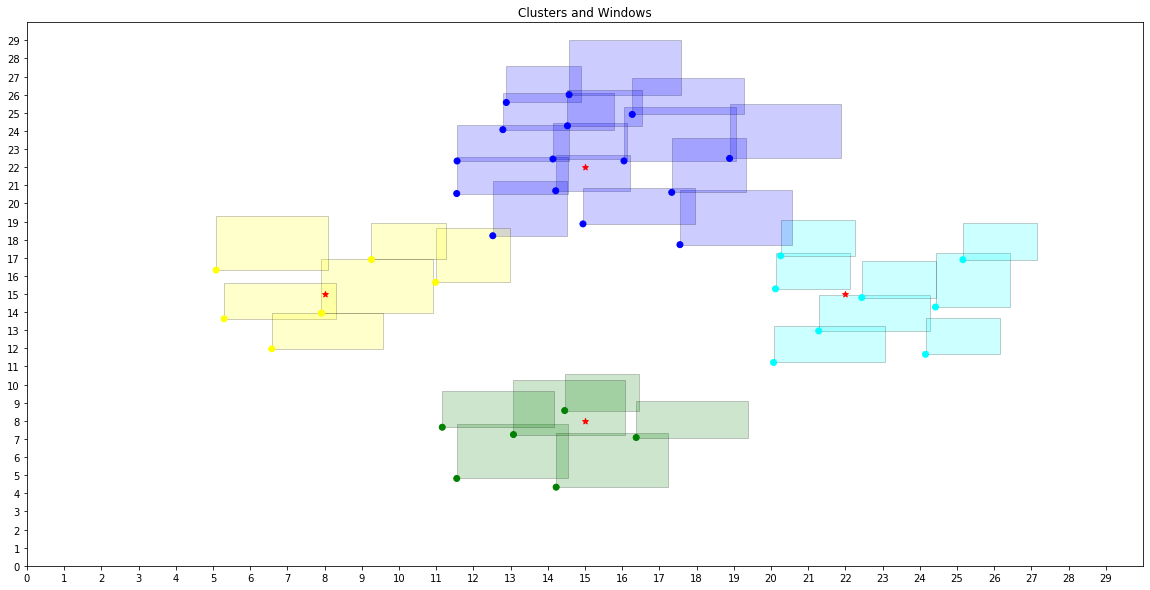

In [10]:
draw_windows(clusters, res["x"].reshape((points.shape[0], 2)), points_dims, points[:,4], n_groups, size_groups)

# 5. Elaboração de relatório